# Crop Identification and Disease Recognition
## Deep Learning Model
## Image Classification with a Convolutional Neural Network
#### Analysis by Ben Geissel

## Introduction
Fill in Text Text Text (Mention poor ML results and need for DL CNN)

In [2]:
# Import necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
import keras
from keras.models import Sequential
from keras.layers import Conv2D , Dropout, MaxPooling2D, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from PIL.Image import core as image
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import image_processing

## Data Exploration
The main data exploration work is located in the Machine Learning notebook. Here I calculate the image class distribution for later use in the notebook.

In [3]:
# Run through image files and determine if any are the wrong shape
# Count images by crop/disease type
data_path = 'PlantVillage-Dataset/raw_image_data/color'
diff_shape_count = 0
img_count = 0
leaf_type_img_count = 0
leaf_type_img_count_dict = {}
for folder in os.listdir(data_path):
    for image in os.listdir('%s/%s' % (data_path, folder)):
        img_loc = '%s/%s/%s' % (data_path, folder, image)
        img = Image.open(img_loc)
        arr = np.array(img)
        img_shape = arr.shape
        img_count += 1
        leaf_type_img_count += 1
        if img_shape != (256, 256, 3):
            diff_shape_count += 1
            print(img_loc)
            print(img_shape)
        else:
            continue
    leaf_type_img_count_dict[folder] = leaf_type_img_count
    leaf_type_img_count = 0
print('Wrong Shape Image Count: %d' % (diff_shape_count))
print('Total Color Image Count: %d' % (img_count))

Wrong Shape Image Count: 0
Total Color Image Count: 54304


## Data Preparation
In the following cells, I will generate arrays for both the image data and class data. The images are converted into numpy arrays of shape (256, 256, 3). Additionally, I will normalize and center the pixel values for each image, which drastically helps the performance of the Convolutional Neural Network. Prepped data will be stored in numpy arrays.

In [3]:
# Run through image files and convert to pixel array and add to list
# Create target list
data_list = []
target_list = []
data_path = 'PlantVillage-Dataset/raw_image_data/color'
for folder in os.listdir(data_path):
    for image in os.listdir('%s/%s' % (data_path, folder)):
        img_loc = '%s/%s/%s' % (data_path, folder, image)
        img_arr = image_processing.image_to_array(img_loc)
        data_list.append(img_arr)
        target_list.append(folder)

In [4]:
# Convert list to array
data_array = np.array(data_list)
target_array = np.array(target_list)

In [5]:
# Normalize Arrays
norm_list = []
for img_array in data_array:
    norm_arr = image_processing.pixel_normalization(img_array)
    norm_list.append(norm_arr)

In [6]:
# Standardize Arrays
standardized_list = []
for norm_arr in norm_list:
    standardized_img_arr = image_processing.pixel_centering(norm_arr)
    standardized_list.append(standardized_img_arr)

In [7]:
# Convert to array
standardized_data_array = np.array(standardized_list)

Split the data into training, validation, and testing sets with an 70/15/15 split. Use a random state for reproduction. In the case of Deep Learning, I split the data into three sets. This is so that when my neural network runs it will train on the training data, validate on the validation data after each epoch. Adjust the weights of the neural network based on validation data performance and retrain the model each epoch. I then have a completely independent set of testing data to make sure my neural network is working properly after final training.

In [8]:
# Train Test Validation Split - 15% testing data, 15% validation data, 70% training data
X_train, X_test, y_train, y_test = train_test_split(standardized_data_array, target_array,
                                                    test_size = .15, random_state = 14)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                 test_size = (1 - .7/.85), random_state = 14)

## Model Preparation
As mentioned previously, I will be using a convolutional neural network. In the following cells I will define certain hyperparameters for the model, label encode my 38 target classes and convert them into binary matrices, create an image data generator, and construct the neural network layer architecture.

In [9]:
# Define epochs, batch size, and number of classes
batch_size = 100
epochs = 25
n_classes = 38

In [10]:
# Label Encode Target Classes
target_class_list = list(leaf_type_img_count_dict.keys())
le = LabelEncoder()
le.fit(target_class_list)
target_class_int_list = list(le.classes_)
y_train = le.transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)

In [11]:
# Convert target class vectors to target class binary matrices
y_train = keras.utils.to_categorical(y_train, num_classes = n_classes)
y_val = keras.utils.to_categorical(y_val, num_classes = n_classes)
y_test = keras.utils.to_categorical(y_test, num_classes = n_classes)

The below piece of code checks to make sure the GPUs are being used on the cloud computing service I used.

In [12]:
# Check to see that GPU is being used
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

The image generator below gathers more data from each image by shifting, rotating, zooming, flipping, etc... This generator is essential to a high performing model in this case. It helped to increase my accuracy by about 15%.

In [13]:
# Create image generator object
img_gen = ImageDataGenerator(width_shift_range = 0.15, height_shift_range = .15, rotation_range = 30, shear_range = .25,
                            zoom_range = .25, horizontal_flip = True)

Below is the architecture for convolutional neural network. The model will consist of convolution layers, pooling layers, dropout layers, and dense layers. All layers use a ReLu activation function except for the final layer, which uses softmax.

In [14]:
# Construct convolutional neural network architecture
model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3), padding = 'same', activation = 'relu', input_shape = (256,256,3)))
model.add(MaxPooling2D(pool_size = (3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))
model.add(Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding = 'same', activation = 'relu'))
model.add(Conv2D(128, (3, 3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation = 'softmax'))

## Running the Model
The model is compiled and run below. The model uses a categorical crossentropy loss/cost function and uses an Adadelta optimizer. As mentioned above, the model uses the training data to train and validates on the validation data. After each epoch, the model adjust the weights throughout the neural network.

In [15]:
# Compile model and run
model.compile(loss = keras.losses.categorical_crossentropy,
              optimizer = keras.optimizers.Adadelta(),
              metrics = ['accuracy', 'mse'])

model_history = model.fit_generator(img_gen.flow(X_train, y_train, batch_size = batch_size),
                                    validation_data = (X_val, y_val),
                                    steps_per_epoch = len(X_train) // batch_size,
                                    epochs = epochs,
                                    verbose = 1)

Epoch 1/25
380/380 [==============================] - 478s 1s/step - loss: 2.7235 - accuracy: 0.2560 - mse: 0.0225 - val_loss: 1.9180 - val_accuracy: 0.4271 - val_mse: 0.0185
Epoch 2/25
380/380 [==============================] - 482s 1s/step - loss: 1.6948 - accuracy: 0.5084 - mse: 0.0166 - val_loss: 1.5150 - val_accuracy: 0.5832 - val_mse: 0.0149
Epoch 3/25
380/380 [==============================] - 480s 1s/step - loss: 1.1266 - accuracy: 0.6596 - mse: 0.0121 - val_loss: 0.6573 - val_accuracy: 0.7941 - val_mse: 0.0076
Epoch 4/25
380/380 [==============================] - 487s 1s/step - loss: 0.8186 - accuracy: 0.7499 - mse: 0.0092 - val_loss: 0.6814 - val_accuracy: 0.8152 - val_mse: 0.0072
Epoch 5/25
380/380 [==============================] - 467s 1s/step - loss: 0.6349 - accuracy: 0.8035 - mse: 0.0074 - val_loss: 0.4591 - val_accuracy: 0.8628 - val_mse: 0.0053
Epoch 6/25
380/380 [==============================] - 479s 1s/step - loss: 0.5203 - accuracy: 0.8394 - mse: 0.0061 - val_loss

## Model Results
Model results are plotted below over the course of the model epochs. You can see both training and validation accuracy increase over the epochs, while the loss decreases over the epochs. Finally, the accuracy and loss for both the validation data and testing data (completely separate data) are shown, with both displaying very good results (97% accuracy!!)

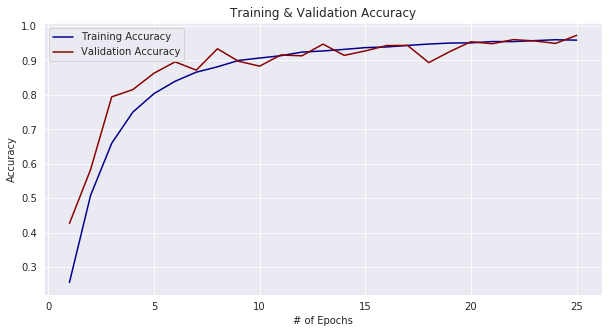

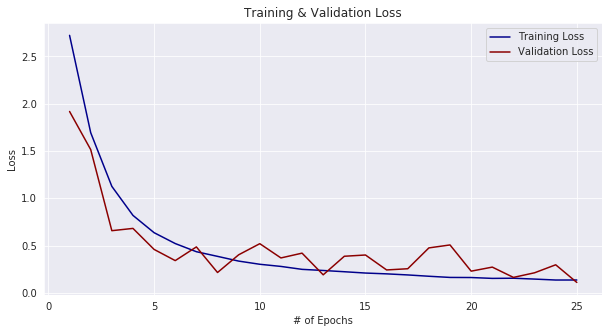

Validation Loss: 0.10985230835749277
Validation Accuracy: 0.972501814365387

Test Loss: 0.10202657610397277
Test Accuracy: 0.972501814365387


In [16]:
# Plotting metrics over epochs
sns.set_style('darkgrid')
model_acc = model_history.history['accuracy']
model_val_acc = model_history.history['val_accuracy']
model_loss = model_history.history['loss']
model_val_loss = model_history.history['val_loss']
model_epochs = range(1, len(model_acc) + 1)
plt.figure(figsize = (10,5))
plt.plot(model_epochs, model_acc, 'darkblue', label = 'Training Accuracy')
plt.plot(model_epochs, model_val_acc, 'darkred', label = 'Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend(loc = 'best')
plt.xlabel('# of Epochs')
plt.ylabel('Accuracy')
plt.show()

plt.figure(figsize = (10,5))
plt.plot(model_epochs, model_loss, 'darkblue', label = 'Training Loss')
plt.plot(model_epochs, model_val_loss, 'darkred', label = 'Validation Loss')
plt.title('Training & Validation Loss')
plt.legend(loc = 'best')
plt.xlabel('# of Epochs')
plt.ylabel('Loss')
plt.show()

# Final Metrics
score = model.evaluate(X_val, y_val, verbose = 0)
print('Validation Loss:', score[0])
print('Validation Accuracy:', score[1])
print()
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test Loss:', score[0])
print('Test Accuracy:', score[1])

In [17]:
# Saving model for future use
model.save("crop_leaves_disease_model.h5")

## Conclusions

Text Text Text (mention DL CNN improvement. Mention what this could mean for users of the model.)